# Clean Data
Clean the Users, Books and Rating Data of the Book Crossing Dataset to be better usable for recommendation.

## Clean User Data

In [335]:
# Load Data.
import pandas as pd

books = pd.read_csv('./BX-Books.csv', sep=";", dtype=str, encoding="iso-8859-1", escapechar='\\', na_filter=False)
ratings = pd.read_csv('./BX-Book-Ratings.csv',sep=';', converters={'user': str, 'isbn': str, 'rating': float} , encoding="iso-8859-1")
users = pd.read_csv('./BX-Users.csv', sep=";", converters={"User-ID": str, "Location":str, "Age": str}, encoding="iso-8859-1", escapechar='\\')

In [456]:
# Clean user data.

# Remove all users where age is NULL or age above 100
import csv
import numpy as np

age_upper_limit = 100
age_lower_limit = 5

# Remove user where age is null
user_age_without_null = users.where(lambda x: x["Age"] != "NULL").dropna()

user_age_without_null["Age"] = list(map(int, user_age_without_null["Age"]))

# Remove users where age not in age limits
user_age_without_null.loc[(user_age_without_null["Age"] < age_lower_limit) | (user_age_without_null["Age"] > age_upper_limit), 'Age'] = np.nan
valid_users =  user_age_without_null.dropna()

# print(sorted(valid_user.Age.unique()))
print(f"Users before: {len(users)}")
print(f"Users without age = Null: {len(user_age_without_null)}")
print(f"User cleaned ({age_lower_limit} age < {age_upper_limit}): {len(valid_users)}") # 166848

# Split location into city, state, country
user_location_expanded = valid_users["Location"].copy().str.split(',', 2, expand=True)
user_location_expanded.columns = ['City', 'State', 'Country']
valid_users = valid_users.join(user_location_expanded)
valid_users.drop(columns=['Location'], inplace=True)
valid_users = valid_users.apply(lambda x: x.str.strip() if x.dtype=='object' else x)

# Save to file
valid_users.to_csv('./BX-User-cleaned.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';', float_format='%.0f')


Users before: 278858
Users without age = Null: 168096
User cleaned (5 age < 100): 166848


<ipython-input-456-35dedd210950>:25: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  user_location_expanded = valid_users["Location"].copy().str.split(',', 2, expand=True)


## Clean Book Data

In [ ]:
%pip install iteration_utilities

In [5]:
# Clean book data. Part 1
# Find duplicates in books according title, author and year.

from iteration_utilities import duplicates

duplicated_book_isbn = list(duplicates(books["ISBN"]))

print(f"Duplicates in books according ISBN: {len(duplicated_book_isbn)}") # no duplicates according isbn found

duplicated_books_title = list(duplicates(books["Book-Title"]))

print(f"Duplicates in books according book Title: {len(duplicated_books_title)}")  # 29225 duplicates according Book-Title found

books_without_duplicated = books.drop_duplicates(
  subset = ["Book-Title", "Book-Author", "Year-Of-Publication"],
  keep = 'last').reset_index(drop = True)

# display(books_without_duplicated)
print(f"Books without duplicates in Title, Author and Publication Year: {len(books_without_duplicated)}") # 267958
print(f"Full books length: {len(books)}") # 271379

books_without_duplicated.to_csv('./BX-Books-cleaned-tmp.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';')

Duplicates in books according ISBN: 0
Duplicates in books according book Title: 29225
Books without duplicates in Title, Author and Publication Year: 267958
Full books length: 271379


In [258]:
# Clean books part 2: Load data and group by author.

import pandas as pd

books = pd.read_csv('./BX-Books-cleaned-tmp.csv', dtype=str, sep=';', na_filter=False, encoding="iso-8859-1", escapechar='\\')

books['Book-Author'] = books['Book-Author'].str.title()

# Group books by author
books = books.reset_index()
books_grouped_by_author = books.groupby("Book-Author", as_index=False)[["ISBN", "Book-Title", "Year-Of-Publication", "index"]].agg({"ISBN": list, "Book-Title":list, "Year-Of-Publication":list, "index":list})

In [189]:
display(books_grouped_by_author)

,Book-Author,ISBN,Book-Title,Year-Of-Publication,index
0,Anne Tyler,"[4689X"", 0425161617, 0425092917, 0517064596, 0...","[The Accidental Tourist, The Accidental Touris...","[1985, 1998, 1994, 1991, 2002, 1994]","[11, 12, 13, 14, 15, 16]"
1,Mark Twain,"[0812504208, 0140620524, 051722108X, 50039, 01...","[The Adventures Of Tom Sawyer, The Adventures ...","[1989, 1994, 2002, 1983, 1998, 1992, 1997, 200...","[3, 4, 5, 6, 7, 8, 9, 10, 17]"
2,Roald Dahl,"[0141311926, 0141311924, 0141311922]","[James And The Giant Peach, The James And The ...","[1999, 2003, 1949]","[0, 1, 2]"


In [259]:
# Clean book data part 2: Merge books with same author and similar title to latest year

# Dependencies.
import csv

# Methods.
def find_simliar_shortest_title(current_title, all_titles):
    title_to_keep = current_title

    contains_title_indices = [i for i, value in enumerate(all_titles) if ((current_title in value or value in current_title))]

    for idx in contains_title_indices:
        if len(all_titles[idx]) < len(title_to_keep):
            title_to_keep = all_titles[idx]
    return title_to_keep

def find_simliar_title_indices(current_title, all_titles):
    return  [i for i, value in enumerate(all_titles) if ((current_title in value or value in current_title))]

# Main Part.
indices_to_keep = []

for i, author in enumerate(books_grouped_by_author["Book-Author"]):

    unique_titles = set()

    for j, title in enumerate(books_grouped_by_author["Book-Title"][i]):
        
        # Search for shortest similiar title
        title_to_keep = find_simliar_shortest_title(title, books_grouped_by_author["Book-Title"][i])
        unique_titles.add(title_to_keep)

    for title in unique_titles:
        title_idx = [x for x, value in enumerate(books_grouped_by_author["Book-Title"][i]) if ((title == value))] 

        # Get indices of similiar titles  
        similar_title_indices = find_simliar_title_indices(title, books_grouped_by_author["Book-Title"][i])

        # Keep latest year from similiar titles  
        latest_year = books_grouped_by_author["Year-Of-Publication"][i][similar_title_indices[0]]
        index_to_keep = books_grouped_by_author["index"][i][similar_title_indices[0]]

        for k, title_idxs in enumerate(similar_title_indices):
            year = books_grouped_by_author["Year-Of-Publication"][i][title_idxs]
            titel = books_grouped_by_author["Book-Title"][i][title_idxs]

            if int(year) > int(latest_year):
                latest_year = year
                index_to_keep = books_grouped_by_author["index"][i][title_idxs]

        indices_to_keep.append((index_to_keep))
        books["Book-Title"][index_to_keep] = title.title()
        books["Book-Author"][index_to_keep] = books["Book-Author"][index_to_keep].title()          

# Drop all indices that where not kept (= not the latest year)
indices_to_drop = [i for i in books.index if i not in indices_to_keep]
cleaned_books = books.drop(indices_to_drop)

print(f"indices_to_keep length {len(indices_to_keep)}")
print(f"indices_to_drop len {len(indices_to_drop)}")
print(f"Final books length {len(cleaned_books)}")
print(f"Previous books length {len(books)}")

# Save cleaned books in new file
cleaned_books = cleaned_books.drop(['index'], axis=1)

# Save to file
cleaned_books.to_csv('./BX-Books-cleaned.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';')

<ipython-input-259-721a8efcdad6>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books["Book-Title"][index_to_keep] = title


indices_to_keep length 228857
indices_to_drop len 39315
Final books length 228643
Previous books length 267958


From now on we will use `./BX-Books-extended.csv` as base for book data. As at this step the books where extended with OpenLibrary.

In [567]:
# Clean books part 3: Clean book titles, publishers, authors and year.

import pandas as pd

books = pd.read_csv('./BX-Books-extended.csv', dtype=str, sep=';', na_filter=False, encoding="iso-8859-1", escapechar='\\')

# Fix & in title and publisher
books['Book-Title'] = books['Book-Title'].str.replace('&amp;', '&', regex=False) 
books["Publisher"] = books["Publisher"].str.replace('&amp;', '&', regex=False)

# Fix publication year to valid range
books["Year-Of-Publication"] = pd.to_numeric(books["Year-Of-Publication"], errors='coerce')
zero_yr = books[books["Year-Of-Publication"] == 0]["Year-Of-Publication"].count()

print(f'Entries with \'0\' in the Year-Of-Publication field:  {zero_yr}')

books.loc[(books["Year-Of-Publication"] == 0) | (books["Year-Of-Publication"] > 2025) | (books["Year-Of-Publication"] < 1800) ,'Year-Of-Publication' ] = np.nan
books["Year-Of-Publication"].fillna(round(books["Year-Of-Publication"].mean()),inplace=True)
books["Year-Of-Publication"] = books["Year-Of-Publication"].astype(int)

print(sorted(books["Year-Of-Publication"].unique()))

Entries with '0' in the Year-Of-Publication field:  3188
[1806, 1897, 1900, 1901, 1902, 1906, 1908, 1909, 1911, 1914, 1917, 1919, 1920, 1921, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024]


In [573]:
# Remove bad characters from book titles:

import re

def remove_bad_chars(text):
    return re.sub('[^a-zA-Z\s/.,:;\-0-9()]+', '', text).title()

display(books[2087:2089])

books['Book-Title'] = books['Book-Title'].apply(remove_bad_chars)
books['Book-Author'] = books['Book-Author'].apply(remove_bad_chars)
books['Publisher'] = books['Publisher'].apply(remove_bad_chars)

display(books[2087:2089])


,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Excerpt,Number-Of-Pages,Publish-Places,Tags
2087,2087,3423241012,"Ich, Meine Freundin Und All Diese Mnner.",Binnie Kirshenbaum,1997,Dtv,http://images.amazon.com/images/P/3423241012.0...,http://images.amazon.com/images/P/3423241012.0...,http://images.amazon.com/images/P/3423241012.0...,,191,[],[]
2088,2088,3423202343,Was Mnner Sagen.,Joan Smith,1999,Dtv,http://images.amazon.com/images/P/3423202343.0...,http://images.amazon.com/images/P/3423202343.0...,http://images.amazon.com/images/P/3423202343.0...,,0,[],[]


,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Excerpt,Number-Of-Pages,Publish-Places,Tags
2087,2087,3423241012,"Ich, Meine Freundin Und All Diese Mnner.",Binnie Kirshenbaum,1997,Dtv,http://images.amazon.com/images/P/3423241012.0...,http://images.amazon.com/images/P/3423241012.0...,http://images.amazon.com/images/P/3423241012.0...,,191,[],[]
2088,2088,3423202343,Was Mnner Sagen.,Joan Smith,1999,Dtv,http://images.amazon.com/images/P/3423202343.0...,http://images.amazon.com/images/P/3423202343.0...,http://images.amazon.com/images/P/3423202343.0...,,0,[],[]


In [574]:
# Apply matching of books again

from iteration_utilities import duplicates

duplicated_books_title = list(duplicates(books["Book-Title"]))
print(f"Duplicates in books according book Title: {len(duplicated_books_title)}")  # 9191 duplicates according Book-Title found

# Group books by author
books = books.reset_index()
books_grouped_by_author = books.groupby("Book-Author", as_index=False)[["ISBN", "Book-Title", "Year-Of-Publication", "index"]].agg({"ISBN": list, "Book-Title":list, "Year-Of-Publication":list, "index":list})

display(books_grouped_by_author)

Duplicates in books according book Title: 9191


In [576]:
# Clean book data part 3: Merge books with same author and similar title to latest year again

# Dependencies.
import csv

# Methods.
def find_simliar_shortest_title(current_title, all_titles):
    title_to_keep = current_title

    contains_title_indices = [i for i, value in enumerate(all_titles) if ((current_title in value or value in current_title))]

    for idx in contains_title_indices:
        if len(all_titles[idx]) < len(title_to_keep):
            title_to_keep = all_titles[idx]
    return title_to_keep

def find_simliar_title_indices(current_title, all_titles):
    return  [i for i, value in enumerate(all_titles) if ((current_title in value or value in current_title))]

# Main Part.
indices_to_keep = []

for i, author in enumerate(books_grouped_by_author["Book-Author"]):

    unique_titles = set()

    for j, title in enumerate(books_grouped_by_author["Book-Title"][i]):
        
        # Search for shortest similiar title
        title_to_keep = find_simliar_shortest_title(title, books_grouped_by_author["Book-Title"][i])
        unique_titles.add(title_to_keep)

    for title in unique_titles:
        title_idx = [x for x, value in enumerate(books_grouped_by_author["Book-Title"][i]) if ((title == value))] 

        # Get indices of similiar titles  
        similar_title_indices = find_simliar_title_indices(title, books_grouped_by_author["Book-Title"][i])

        # Keep latest year from similiar titles  
        latest_year = books_grouped_by_author["Year-Of-Publication"][i][similar_title_indices[0]]
        index_to_keep = books_grouped_by_author["index"][i][similar_title_indices[0]]

        for k, title_idxs in enumerate(similar_title_indices):
            year = books_grouped_by_author["Year-Of-Publication"][i][title_idxs]
            titel = books_grouped_by_author["Book-Title"][i][title_idxs]

            if int(year) > int(latest_year):
                latest_year = year
                index_to_keep = books_grouped_by_author["index"][i][title_idxs]

        indices_to_keep.append((index_to_keep))
        books["Book-Title"][index_to_keep] = title.title()
        books["Book-Author"][index_to_keep] = books["Book-Author"][index_to_keep].title()          

# Drop all indices that where not kept (= not the latest year)
indices_to_drop = [i for i in books.index if i not in indices_to_keep]
cleaned_books = books.drop(indices_to_drop)

print(f"indices_to_keep length {len(indices_to_keep)}")
print(f"indices_to_drop len {len(indices_to_drop)}")
print(f"Final books length {len(cleaned_books)}")
print(f"Previous books length {len(books)}")

# Save cleaned books in new file
cleaned_books = cleaned_books.drop(['index', 'level_0'], axis=1)

# Save to file
cleaned_books.to_csv('./BX-Books-cleaned-final.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';')

<ipython-input-576-2519176bcd55>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books["Book-Title"][index_to_keep] = title.title()
<ipython-input-576-2519176bcd55>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books["Book-Author"][index_to_keep] = books["Book-Author"][index_to_keep].title()


indices_to_keep length 228144
indices_to_drop len 499
Final books length 228144
Previous books length 228643


In [79]:
# Clean books data: excerpt and tags.

import pandas as pd
import re
import csv

# Load cleaned books
books = pd.read_csv('./BX-Books-cleaned-final.csv', dtype=str, sep=';', na_filter=False, encoding='iso-8859-1', escapechar='\\')

# Remove bad characters from excerpt:

def remove_bad_chars(text):
    return re.sub('[^a-zA-Z\s/.,:;\-0-9()]+', '', text).title()

books['Excerpt'] = books['Excerpt'].apply(remove_bad_chars)
books['Tags'] = books['Tags'].apply(remove_bad_chars)

# Clean Tags. Remove duplicates, remove tags longer than 20 characters.
tags = list()
for idx in books.index:
    book_tags = books["Tags"][idx].strip('\'][\'').split('\', \'')[0].split(',')
    tags_small_enough = [i.strip(",./- ") for i in book_tags if i.strip(",./- ") and len(i.strip(",./- ")) <= 20]

    books["Tags"][idx] = list(set(tags_small_enough))
    tags.extend(set(tags_small_enough))
 
# Duplicated tags 1409688
# Unique tags  93296
# Unique tags after < 20 character filter 58801

# Save to file
books.to_csv('./BX-Books-cleaned-final-tags.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';')


## Clean Rating Data

In [578]:
# Load cleaned books and user data.

cleaned_books = pd.read_csv('./BX-Books-cleaned.csv', dtype=str, sep=';', encoding="iso-8859-1")
cleaned_users = pd.read_csv('./BX-User-cleaned.csv', dtype=str, sep=';', encoding="iso-8859-1")

# Add leading 0 to isbns in ratings.
ratings['isbn'] = ratings['isbn'].apply(lambda x: '{0:0>10}'.format(x))

In [585]:
# Clean rating data.
# Filter invalid isbns. Only A-Z and  0-9 are allowed in valid isbns.

import re

isbn_reg = re.compile(r'[^A-Z0-9]')

def is_valid_isbn(isbn):
    result = isbn_reg.search(isbn)
    return not bool(result)

def isbn_filter(isbn):
    return is_valid_isbn(isbn)

print(f"Cleaned ratings length before: {len(ratings)}") # 1048575

cleaned_ratings = ratings[ratings["isbn"].apply(isbn_filter)]

print(f"Cleaned ratings length after: {len(cleaned_ratings)}") # 1045704


Cleaned ratings length before: 1048575
Cleaned ratings length after: 1045704


In [580]:
# Group ratings by user

cleaned_ratings2 = cleaned_ratings.reset_index()
ratings_grouped_by_user = cleaned_ratings2.groupby("user", as_index=False)[["isbn", "index"]].agg({"isbn": list, "index":list})

display(ratings_grouped_by_user)

,user,isbn,index
0,10,"[1841721522, 8477024456]","[9584, 9585]"
1,100,[0431111110],[9684]
2,1000,[8850200005],[12068]
3,100001,[0425182673],[418979]
4,100002,[0345397819],[418980]
...,...,...,...
95060,99992,[038097617X],[418921]
95061,99993,"[3423126949, 3492227694, 3499231573, 3548304192]","[418922, 418923, 418924, 418925]"
95062,99996,"[0006385621, 006103083X, 0099422042, 009972741...","[418926, 418927, 418928, 418929, 418930, 41893..."
95063,99997,"[0156001942, 0316666343, 0345443284, 037550603...","[418970, 418971, 418972, 418973, 418974, 41897..."


In [581]:
# Find users that need to be dropped

invalid_ratings_users = [idx for idx, user in enumerate(ratings_grouped_by_user["user"]) if user not in cleaned_users['User-ID'].values]

In [584]:
print(sorted(invalid_ratings_users))

[3, 4, 5, 8, 9, 11, 13, 14, 15, 16, 20, 21, 28, 33, 35, 38, 44, 46, 47, 49, 50, 51, 52, 55, 57, 58, 59, 62, 67, 68, 72, 73, 75, 80, 85, 87, 88, 89, 95, 96, 101, 110, 111, 112, 117, 118, 119, 120, 121, 124, 125, 129, 130, 131, 134, 135, 137, 140, 141, 143, 145, 148, 150, 151, 152, 155, 156, 160, 161, 162, 166, 167, 171, 172, 173, 174, 176, 179, 182, 183, 184, 192, 194, 205, 209, 210, 212, 213, 216, 218, 226, 232, 233, 234, 236, 237, 238, 241, 245, 247, 251, 253, 254, 255, 256, 266, 270, 271, 272, 273, 274, 276, 277, 281, 282, 286, 291, 292, 296, 299, 300, 301, 305, 307, 309, 311, 312, 315, 321, 322, 324, 325, 329, 336, 339, 340, 343, 345, 346, 347, 349, 356, 359, 360, 361, 366, 367, 368, 371, 372, 374, 378, 379, 380, 383, 384, 387, 392, 393, 396, 397, 400, 401, 410, 411, 413, 416, 426, 427, 432, 434, 435, 437, 439, 442, 444, 446, 455, 458, 459, 460, 464, 465, 469, 470, 471, 476, 479, 481, 482, 483, 484, 485, 487, 488, 490, 492, 495, 497, 501, 502, 503, 509, 513, 514, 517, 519, 524, 526,

In [586]:
# Remove all ratings from non existing users

# Find indices that need to be dropped from rating data
invalid_ratings_users_indices = []
for user_idx in invalid_ratings_users:
    invalid_ratings_users_indices.extend(ratings_grouped_by_user["index"][user_idx])

# Drop not found indices from original ratings data
user_cleaned_ratings = cleaned_ratings.drop(invalid_ratings_users_indices)

print(f"Cleaned ratings length before: {len(cleaned_ratings)}") # 1045704
print(f"Invalid user ratings length {len(invalid_ratings_users_indices)}") # 289044
print(f"User cleaned ratings length {len(user_cleaned_ratings)}") # 756660

# Save to tmp file
user_cleaned_ratings.to_csv('./BX-Book-Ratings-cleaned-tmp.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';')

Cleaned ratings length before: 1045704
Invalid user ratings length 289044
User cleaned ratings length 756660


In [592]:
# Load new user cleaned data as base.

user_cleaned_ratings = pd.read_csv('./BX-Book-Ratings-cleaned-tmp.csv', converters={'user': str, 'isbn': str, 'rating': float} , sep=';', encoding="iso-8859-1")
cleaned_books = pd.read_csv('./BX-Books-cleaned-final.csv', dtype=str, sep=';', na_filter=False, encoding='iso-8859-1', escapechar='\\')
original_books = pd.read_csv('./BX-Books.csv', sep=";", dtype=str, encoding="iso-8859-1", escapechar='\\', na_filter=False)

In [588]:
# Group ratings by isbn.

user_cleaned_ratings = user_cleaned_ratings.reset_index()
ratings_grouped_by_isbn = user_cleaned_ratings.groupby("isbn", as_index=False)[["user", "index"]].agg({"user": list, "index":list})

display(ratings_grouped_by_isbn)

,isbn,user,index
0,0000000000,"[6360, 8094, 8094, 11795, 11795, 11795, 11795,...","[17081, 21939, 21940, 29167, 29168, 29169, 291..."
1,0000000010,[29553],[77886]
2,0000000020,[29553],[77887]
3,0000000051,[143175],[424664]
4,0000001481,[175886],[526928]
...,...,...,...
266417,UNGRANDHOMMED,[172888],[515946]
266418,VENAFRO001,[86153],[247137]
266419,X000000000,[19355],[51365]
266420,XXXXXXXXXX,[135172],[401886]


In [589]:
# Find isbns in ratings that are no longer present in books data.
# They need to be changed to the one book source that was kept as part of duplicates.

print(f"Length before: {len(user_cleaned_ratings)}") # 760858

invalid_ratings_isbns = [idx for idx, isbn in enumerate(ratings_grouped_by_isbn["isbn"]) if isbn not in cleaned_books['ISBN'].values]

print(f"Invalid Rating ISBNS: {len(invalid_ratings_isbns)}") # 85713

Length before: 756660
Invalid Rating ISBNS: 86124


In [606]:
# Find indices of isbns that need to be replaced and replace with new book source ISBN.
import pandas as pd
import csv

invalid_isbns_indexes = []

for invalid_isbn_idx in invalid_ratings_isbns:
    invalid_isbn = ratings_grouped_by_isbn["isbn"][invalid_isbn_idx]

    # Search for book entry in original book data with isbn
    row = original_books.loc[original_books['ISBN'] == invalid_isbn]

    # Isbn not found. Drop all indices from ratings later.
    if(row.empty):
        invalid_isbns_indexes.extend(ratings_grouped_by_isbn["index"][invalid_isbn_idx])
        continue
    
    title = row['Book-Title'].values[0].title()
    author = row['Book-Author'].values[0].title()

    # Find new index and isbn of book and change isbn
    new_book_source = [x for x, value in enumerate(cleaned_books["Book-Title"]) if ((title in value) or value in title) and (cleaned_books['Book-Author'][x] == author)] 
    # print(f"Title: {title}, Author: {author}, new book source: {new_book_source}")

    # No new book source found. Drop rating later.
    if(len(new_book_source) == 0):
        invalid_isbns_indexes.extend(ratings_grouped_by_isbn["index"][invalid_isbn_idx])
        continue

    new_isbn = cleaned_books['ISBN'][new_book_source[0]]

    # For all indices in ratings where the current isbn is used replace with new isbn
    for isbn_book_index in ratings_grouped_by_isbn["index"][invalid_isbn_idx]:
        user_cleaned_ratings.at[isbn_book_index, 'isbn'] = new_isbn

final_cleaned_ratings = user_cleaned_ratings.drop(invalid_isbns_indexes)

print(f"Invalid isbns that could not be matched: {len(invalid_isbns_indexes)}")
print(f"Ratings cleaned length: {len(final_cleaned_ratings)}") 
print(f"Original Ratings length: {len(ratings)}") 

# Save to file
final_cleaned_ratings.to_csv('./BX-Book-Ratings-cleaned.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';')


Invalid isbns that could not be matched: 100367
Ratings cleaned length: 656293
Original Ratings length: 1048575


In [607]:
# Clean ratings. Remove ratings = 0. 
# In the documentation is stated that the 0 ratings are implicit feedback.

import pandas as pd
import csv

cleaned_ratings = pd.read_csv('./BX-Book-Ratings-cleaned.csv', converters={'user': str, 'isbn': str, 'rating': float} , sep=';')
ratings_without_0 = cleaned_ratings.where(lambda x: x["rating"] > 0.0 ).dropna()

print(f"Ratings: {len(cleaned_ratings)}") #760858
print(f"Ratings without 0: {len(ratings_without_0)}") #278261

ratings_without_0.to_csv('./BX-Book-Ratings-cleaned-without-0.csv', index=False, header=True, quoting=csv.QUOTE_ALL, sep=';', float_format='%.0f')

Ratings: 656293
Ratings without 0: 235563


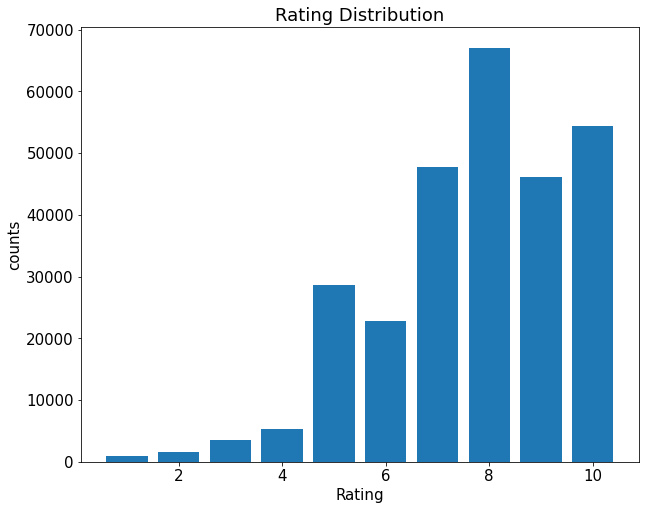

In [518]:
# Plot new rating distribution.

from matplotlib import pyplot as plt

rtg = ratings_without_0['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.title('Rating Distribution')
plt.show()